# Initial Setup

## Libraries

In [1]:
!pip install soundfile

In [2]:
import warnings
import sys
warnings.filterwarnings('ignore')

import numpy as np
import scipy
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm
import soundfile as sf

import matplotlib.pyplot as plt
import IPython.display as ipd

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Activation, Conv1D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_squared_error
import tensorflow.keras.backend as kb

In [4]:
print("=== Library Versions ===")
print("SciPy:     ",scipy.__version__)
print("Numpy:     ",np.__version__)
print("TensorFlow:",tf.__version__)
print("Keras:     ",keras.__version__)
print("Soundfile: ",sf.__version__)

=== Library Versions ===
SciPy:      1.4.1
Numpy:      1.18.5
TensorFlow: 2.3.0
Keras:      2.4.0
Soundfile:  0.10.3


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Custom Functions

In [6]:
# Convolute two audio signals
def conv(source, impulse):
  split = source.split('.')
  conv_output = '.'.join(split[:-1])+'_conv.' + split[-1]

  clip_factor = 1.01 # clip factor default value

  h1, Fs1 = sf.read( impulse ) # impulse response
  x1, Fs2 = sf.read( source ) # file to process

  if Fs1 == Fs2 : # if sample rates are the same
    print("Processing...")
    y1 = signal.fftconvolve(x1,h1).real # takes the real part to avoid a too small complex part (around e-18)

    # audio normalization: if "y = y/max(y)" -> "values out of [-1,+1] range are clipped"
    y1 = y1/( max(y1)*clip_factor ) # to avoid clipping
    
    sf.write( conv_output, y1, Fs1 )

    print("Output file:", conv_output)
    print("Convolution success.")

    return conv_output
  else:
    print("Error: files has different sample rate.")

In [7]:
# Function: Convert some hex value into an array for C programming
# Source: Machine Learning on Microcontroller Lecture, ETH Zurich
def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [8]:
# Error-to-Signal Ratio
def ESR(y_actual,y_predicted):
    return kb.sum(kb.square(y_actual-y_predicted),axis=0)/(kb.sum(kb.square(y_actual),axis=0)+tf.keras.backend.epsilon())

In [9]:
class AudioSequence(Sequence):
  def __init__(self, x_set, y_set, batch_size, rec_field, shuffle=False):
    self.x, self.y = x_set, y_set
    self.rec_field = rec_field
    self.batch_size = batch_size
    self.shuffle = shuffle

     # Matrix, each column containing the previous N input samples
    self.batch_x = np.empty((self.batch_size ,self.rec_field,1))
    # Vector, each entry containing the current output samples
    self.batch_y = np.empty((self.batch_size ,1,1))

    self.order = np.arange(0, self.__len__())

    if self.shuffle:
      self.order = np.random.randint(0,self.__len__(),self.__len__())

  def __len__(self):
    return np.math.floor((len(self.x)-self.rec_field) / self.batch_size)

  def __getitem__(self, idx, ):
    batch = self.order[idx]*self.batch_size
   
    self.batch_x[:,:,0] = np.lib.stride_tricks.as_strided(
        self.x[batch:batch+self.rec_field+self.batch_size],
        (self.batch_size, self.rec_field), 
        (8, 8),
        writeable=False
    )
    self.batch_y[:,0,0] = self.y[batch+self.rec_field:batch+self.rec_field+self.batch_size]

    return np.array(self.batch_x), np.array(self.batch_y)

  def on_epoch_end(self):
    if self.shuffle:
      self.order = np.random.randint(0,self.__len__(),self.__len__())

In [10]:
def generate_dataset(audio_input, audio_amp, rec_field, samples=-1):
    if samples == -1 or samples < 0:
      samples = len(audio_input)-rec_field

    # Matrix, each column containing the previous N input samples
    X = np.empty((samples ,rec_field,1))
    # Vector, each entry containing the current output samples
    y = np.empty((samples ,1,1))
   
    X[:,:,0] = np.lib.stride_tricks.as_strided(
        audio_input,
        (samples, rec_field), 
        (8, 8),
        writeable=False
    )
    y[:,0,0] = audio_amp[rec_field:rec_field+samples]

    return X, y

# Configuration

In [11]:
# Neural Network
CHANNELS    = 8
KERNEL_SIZE = 3
EPOCHS      = 10
BATCH_SIZE  = 256
BATCH_SIZE_PREDICT = 1024

HOME_FOLDER = '/content/drive/MyDrive/Colab Notebooks/'

# Model Description
ITERATION = 2
NAME = 'OrangeMicroDark'
IDENTIFIER = 'WN12'
VERSION = 2

# Data
TEST_DURATION = 10    # seconds
SHUFFLE       = True

TRAIN_TEST_SPLIT = 0.85 # Use 60% for training
TRAIN_VAL_SPLIT  = 0.9 # Use another 60% of the remaining data for training and 30% for validation

TRAIN_AUDIO_IN  = HOME_FOLDER + 'Datasets/OrangeMicroDark/OrangeMicroDark_in.wav'
TRAIN_ADUIO_AMP = HOME_FOLDER + 'Datasets/OrangeMicroDark/OrangeMicroDark_disto.wav'
IMPULSE_AUDIO  = HOME_FOLDER + 'Datasets/GuitarCabinetIR.wav'

# Models
WN10 = [1,2,4,8,16,32,64,128,256,512]
WN12 = [1,2,4,8,16,32,1,2,4,8,16,32]
WN18 = [1,2,4,8,16,32,64,128,256,1,2,4,8,16,32,64,128,256]
WN24 = [1,2,4,8,16,32,64,128,1,2,4,8,16,32,64,128,1,2,4,8,16,32,64,128]

print('=== Receptive Fields ===')
N = (KERNEL_SIZE-1)*np.sum(WN10)+1
print("WN{}: {:4d} samples".format(len(WN10), N))

N = (KERNEL_SIZE-1)*np.sum(WN12)+1
print("WN{}: {:4d} samples".format(len(WN12), N))

N = (KERNEL_SIZE-1)*np.sum(WN18)+1
print("WN{}: {:4d} samples".format(len(WN18), N))

N = (KERNEL_SIZE-1)*np.sum(WN24)+1
print("WN{}: {:4d} samples".format(len(WN24), N))

=== Receptive Fields ===
WN10: 2047 samples
WN12:  253 samples
WN18: 2045 samples
WN24: 1531 samples


In [12]:
if IDENTIFIER == 'WN10':
  DILATATION_RATES = WN10
elif IDENTIFIER == 'WN12':
  DILATATION_RATES = WN12
elif IDENTIFIER == 'WN18':
  DILATATION_RATES = WN18
elif IDENTIFIER == 'WN24':
  DILATATION_RATES = WN24
else:
  print("ERROR!")

REC_FIELD = (KERNEL_SIZE-1)*np.sum(DILATATION_RATES)+1

print("Using Mode:     ", IDENTIFIER)
print("Receptive Field:", REC_FIELD)

Using Mode:      WN12
Receptive Field: 253


In [13]:
MODEL_NAME = '{:02d}_{}_{}_v{:d}'.format(ITERATION,NAME,IDENTIFIER,VERSION) 
MODEL_PATH = '{}{:02d}_Data/{}'.format(HOME_FOLDER, ITERATION,MODEL_NAME) 

print("=== File Configuration ===")
print("Model Name :", MODEL_NAME)
print("Audio Input:", TRAIN_AUDIO_IN)
print("Audio Amp  :", TRAIN_ADUIO_AMP)
print("Impulse R. :", IMPULSE_AUDIO)
print("Model Path :", MODEL_PATH)


=== File Configuration ===
Model Name : 02_OrangeMicroDark_WN12_v2
Audio Input: /content/drive/MyDrive/Colab Notebooks/Datasets/OrangeMicroDark/OrangeMicroDark_in.wav
Audio Amp  : /content/drive/MyDrive/Colab Notebooks/Datasets/OrangeMicroDark/OrangeMicroDark_disto.wav
Impulse R. : /content/drive/MyDrive/Colab Notebooks/Datasets/GuitarCabinetIR.wav
Model Path : /content/drive/MyDrive/Colab Notebooks/02_Data/02_OrangeMicroDark_WN12_v2


# Preprocessing

## Import Audio

In [14]:
#ipd.Audio(TRAIN_AUDIO_IN)

In [15]:
#ipd.Audio(TRAIN_ADUIO_AMP)

In [16]:
# Import audio data
srate, audio_input = wavfile.read(TRAIN_AUDIO_IN)
_, audio_amp       = wavfile.read(TRAIN_ADUIO_AMP)

print('Total number of input samples: ' + str(np.size(audio_input)))
print('Total number of output samples: ' + str(np.size(audio_amp)))

Total number of input samples: 3068547
Total number of output samples: 3068547


## Build Dataset

In [17]:
# Convert to numpy array and re-scale 16-bit wave file to [-1,1]
audio_input = np.array(audio_input)/2**15
audio_amp   = np.array(audio_amp)/2**15

In [18]:
# OLD CODE

# N_data    = len(audio_input)
# N_tests   = int(N_data/10.0)
# X = np.empty((N_tests,REC_FIELD,1))        # Matrix, each column containing the previous N input samples
# y = np.empty((N_tests,1,1))                # Vector, each entry containing the current output samples
# 
# for i in tqdm(range(N_tests)):
#     pos      = np.random.randint(REC_FIELD,N_data)  # Pick random position in audio file
#     X[i,:,0] = audio_input[pos-REC_FIELD:pos]       # Add last N input samples to column of input data
#     y[i,0,0] = audio_amp[pos]                       # Add current input sample to output data
# 
# assert X.size == y.size * REC_FIELD

In [19]:
index_test  = int(np.size(audio_input)*(1-TRAIN_TEST_SPLIT))
index_val   = int(np.size(audio_input)*(1-TRAIN_VAL_SPLIT)*TRAIN_TEST_SPLIT)+index_test
index_train = int(np.size(audio_input)*TRAIN_VAL_SPLIT*TRAIN_TEST_SPLIT)+index_test

test_audio_input  = audio_input[0:index_test-REC_FIELD]
val_audio_input   = audio_input[index_test:index_val-REC_FIELD]
train_audio_input = audio_input[index_val:]

test_audio_amp    = audio_amp[0:index_test-REC_FIELD]
val_audio_amp     = audio_amp[index_test:index_val-REC_FIELD]
train_audio_amp   = audio_amp[index_val:]

print("Test Size  : {:7d} samples, {:.2f} s".format(test_audio_input.shape[0], test_audio_input.shape[0]/srate))
print("Val Size   : {:7d} samples, {:.2f} s".format(val_audio_input.shape[0], val_audio_input.shape[0]/srate))
print("Train Size : {:7d} samples, {:.2f} s".format(train_audio_input.shape[0], train_audio_input.shape[0]/srate))
print()
print("Test Size  : {:7d} samples, {:.2f} s".format(test_audio_amp.shape[0], test_audio_amp.shape[0]/srate))
print("Val Size   : {:7d} samples, {:.2f} s".format(val_audio_amp.shape[0], val_audio_amp.shape[0]/srate))
print("Train Size : {:7d} samples, {:.2f} s".format(train_audio_amp.shape[0], train_audio_amp.shape[0]/srate))

test_audio_input_padded = np.pad(test_audio_input, (REC_FIELD,0) )
test_audio_amp_padded   = np.pad(test_audio_amp, (REC_FIELD,0) )

seq_test  = AudioSequence(test_audio_input_padded,  test_audio_amp_padded,  BATCH_SIZE_PREDICT, REC_FIELD)
seq_train = AudioSequence(train_audio_input, train_audio_amp, BATCH_SIZE, REC_FIELD, shuffle=SHUFFLE)
seq_val   = AudioSequence(val_audio_input,   val_audio_amp,   BATCH_SIZE_PREDICT, REC_FIELD, shuffle=SHUFFLE)

Test Size  :  460029 samples, 10.43 s
Val Size   :  260573 samples, 5.91 s
Train Size : 2347439 samples, 53.23 s

Test Size  :  460029 samples, 10.43 s
Val Size   :  260573 samples, 5.91 s
Train Size : 2347439 samples, 53.23 s


(1024, 253, 1) (1024, 1, 1)


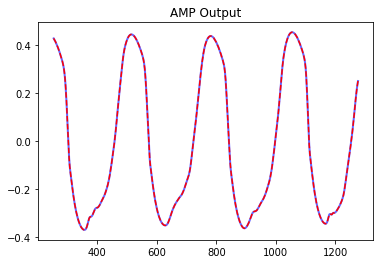

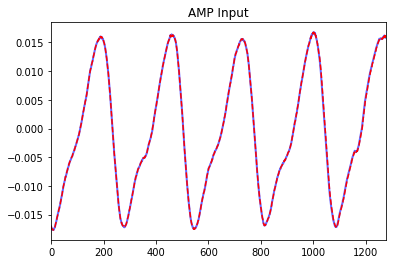

In [20]:
d = generate_dataset(train_audio_input, train_audio_amp, 253, BATCH_SIZE_PREDICT)
print(d[0].shape,d[1].shape)

plt.plot(np.arange(REC_FIELD, BATCH_SIZE_PREDICT+REC_FIELD),train_audio_amp[REC_FIELD:REC_FIELD+BATCH_SIZE_PREDICT], 'b-', linewidth=2, alpha=0.6)
plt.plot(np.arange(REC_FIELD, BATCH_SIZE_PREDICT+REC_FIELD), d[1].reshape(-1), 'r--')
plt.title("AMP Output")
#plt.xlim([0,BATCH_SIZE_PREDICT+REC_FIELD])
plt.show()

plt.plot(train_audio_input[:BATCH_SIZE_PREDICT+REC_FIELD], 'b-', linewidth=2, alpha=0.6)
plt.plot(np.arange(0, BATCH_SIZE_PREDICT), d[0][:,0].reshape(-1), 'r--')
plt.plot(np.arange(BATCH_SIZE_PREDICT, REC_FIELD+BATCH_SIZE_PREDICT), d[0][-1,:].reshape(-1), 'r--')
plt.xlim([0,BATCH_SIZE_PREDICT+REC_FIELD])
plt.title("AMP Input")
plt.show()

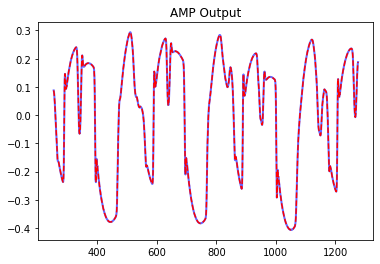

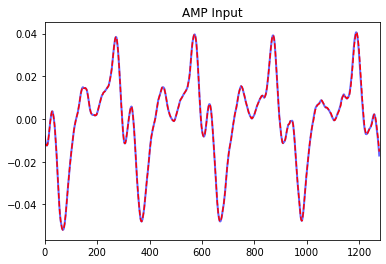

In [22]:
INDEX = 10
plt.plot(np.arange(REC_FIELD, BATCH_SIZE_PREDICT+REC_FIELD),test_audio_amp_padded[INDEX*BATCH_SIZE_PREDICT+REC_FIELD:REC_FIELD+(1+INDEX)*BATCH_SIZE_PREDICT], 'b-', linewidth=2, alpha=0.6)
plt.plot(np.arange(REC_FIELD, BATCH_SIZE_PREDICT+REC_FIELD), seq_test.__getitem__(INDEX)[1].reshape(-1), 'r--')
plt.title("AMP Output")
#plt.xlim([0,BATCH_SIZE_PREDICT+REC_FIELD])
plt.show()

plt.plot(test_audio_input_padded[INDEX*BATCH_SIZE_PREDICT:(1+INDEX)*BATCH_SIZE_PREDICT+REC_FIELD], 'b-', linewidth=2, alpha=0.6)
plt.plot(np.arange(0, BATCH_SIZE_PREDICT), seq_test.__getitem__(INDEX)[0][:,0].reshape(-1), 'r--')
plt.plot(np.arange(BATCH_SIZE_PREDICT, REC_FIELD+BATCH_SIZE_PREDICT), seq_test.__getitem__(INDEX)[0][-1,:].reshape(-1), 'r--')
plt.xlim([0,BATCH_SIZE_PREDICT+REC_FIELD])
plt.title("AMP Input")
plt.show()

In [ ]:
ipd.Audio(data=test_audio_input_padded,rate=srate)

In [ ]:
ipd.Audio(data=test_audio_amp_padded,rate=srate)

# Neural Network

## Definition

In [ ]:
# Creating the model from the paper
model = Sequential( name = MODEL_NAME)

model.add(Input(shape = (REC_FIELD,1)))

for i in DILATATION_RATES:
  model.add(Conv1D(CHANNELS, KERNEL_SIZE, dilation_rate=i,activation='softsign'))


model.layers[-1].filters = 1
model = model_from_json(model.to_json())

In [ ]:
# Display a summary of the model (number of layers and parameters, ect)
model.summary()

Model: "02_OrangeMicroDark_WN10_v3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2045, 8)           32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2041, 8)           200       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2033, 8)           200       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2017, 8)           200       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1985, 8)           200       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1921, 8)           200       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1793

In [ ]:
# Compile model (define optimization algorithm, loss function)
model.compile(optimizer=Adam(learning_rate=0.001),loss=ESR)

## Training

In [ ]:
# D_DATA = len(train_audio_input)-REC_FIELD
# Matrix, each column containing the previous N input samples
# X = np.lib.stride_tricks.as_strided(train_audio_input, (D_DATA, REC_FIELD), (8, 8), writeable=False)
# Vector, each entry containing the current output samples
# y = train_audio_amp[REC_FIELD:]

In [ ]:
# Train the network
history = model.fit(seq_train, validation_data=seq_val, epochs = EPOCHS, max_queue_size=200)

Epoch 1/10
9161/9161 [==============================] - 778s 85ms/step - loss: 0.6003 - val_loss: 0.2938
Epoch 2/10
9161/9161 [==============================] - 777s 85ms/step - loss: 0.2818 - val_loss: 0.2027
Epoch 3/10
9161/9161 [==============================] - 769s 84ms/step - loss: 0.1925 - val_loss: 0.2243
Epoch 4/10
9161/9161 [==============================] - 779s 85ms/step - loss: 0.2420 - val_loss: 0.1595
Epoch 5/10
9161/9161 [==============================] - 765s 84ms/step - loss: 0.1922 - val_loss: 0.1973
Epoch 6/10
9161/9161 [==============================] - 769s 84ms/step - loss: 0.1581 - val_loss: 0.1882
Epoch 7/10
9161/9161 [==============================] - 773s 84ms/step - loss: 0.1725 - val_loss: 0.1443
Epoch 8/10
9161/9161 [==============================] - 772s 84ms/step - loss: 0.1605 - val_loss: 0.2288
Epoch 9/10
9161/9161 [==============================] - 774s 84ms/step - loss: 0.1539 - val_loss: 0.1312
Epoch 10/10
9161/9161 [==============================] 

In [ ]:
# Free as much memory as pssible
# del X, y
# Save the model
model.save(MODEL_PATH + '.h5') 

## Evaluation

dict_keys(['loss', 'val_loss'])


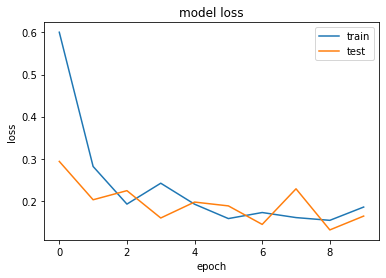

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [26]:
LOAD_MODEL = MODEL_PATH
#LOAD_MODEL = '/content/drive/MyDrive/Colab Notebooks/02_OrangeMicroDark_WN12_v2'

model = tf.keras.models.load_model(LOAD_MODEL + '.h5', custom_objects={'ESR': ESR})
print("Loading Model:", LOAD_MODEL + '.h5')

Loading Model: /content/drive/MyDrive/Colab Notebooks/02_Data/02_OrangeMicroDark_WN12_v2.h5


In [27]:
print("Evaluate on test data")
results = model.evaluate(seq_test, workers=1, max_queue_size=20, steps=np.floor(TEST_DURATION*srate/BATCH_SIZE_PREDICT), verbose=1)
print("Test ESR: {:.2f}%".format(100*results))

Evaluate on test data
430/430 [==============================] - 3s 7ms/step - loss: 0.1889
Test ESR: 18.89%


In [ ]:
print("Generate Output")
audio_pred = model.predict(seq_test, workers=1, max_queue_size=20, steps=np.ceil(TEST_DURATION*srate/BATCH_SIZE_PREDICT), verbose=1)
wavfile.write(LOAD_MODEL + '.wav', srate, audio_pred[:,0,0])

Generate Output
431/431 [==============================] - 25s 57ms/step


In [ ]:
ipd.Audio(audio_pred[:,0,0], rate=srate)

In [29]:
# Convolute signal with impulse respons from loudspeaker
audio_path = conv(LOAD_MODEL + '.wav', IMPULSE_AUDIO)

Processing...
Output file: /content/drive/MyDrive/Colab Notebooks/02_Data/02_OrangeMicroDark_WN12_v2_conv.wav
Convolution success.


In [30]:
ipd.Audio(audio_path)

# Post Training Quantization

In [20]:
LOAD_MODEL = MODEL_PATH
#LOAD_MODEL = '/content/drive/MyDrive/Colab Notebooks/02_OrangeMicroDark_WN12_v2'

model = tf.keras.models.load_model(LOAD_MODEL + '.h5', custom_objects={'ESR': ESR})
print("Loading Model:", LOAD_MODEL + '.h5')

tf.saved_model.save(model, MODEL_PATH+'/')

Loading Model: /content/drive/MyDrive/Colab Notebooks/02_Data/02_OrangeMicroDark_WN12_v2.h5
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/02_Data/02_OrangeMicroDark_WN12_v2/assets


In [3]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_saved_model( MODEL_PATH+'/')
# Convert the model to the TensorFlow Lite format with quantization
quantize = True

if (quantize):    
  def representative_dataset():
    dataset = generate_dataset(train_audio_input, train_audio_amp, REC_FIELD, 500)[0]
    for i in range(500):
      yield([dataset[i].astype(np.float32).reshape(1,REC_FIELD,1)]) 

  # Set the optimization flag.
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  # Enforce full-int8 quantization
  converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
  ]

  converter.inference_input_type = tf.int8  # or tf.uint8
  converter.inference_output_type = tf.int8  # or tf.uint8

  # Provide a representative dataset to ensure we quantize correctly.
  converter.representative_dataset = representative_dataset
  
tflite_model = converter.convert()

open(LOAD_MODEL + '_lite' + '.tflite', 'wb').write(tflite_model)

NameError: ignored

In [2]:
# Write TFLite model to a C source (or header) file
with open(LOAD_MODEL + '_lite' + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

NameError: ignored

In [1]:
tflite_interpreter = tf.lite.Interpreter(model_path=LOAD_MODEL + '_lite' + '.tflite')
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

NameError: ignored

In [ ]:
predictions = np.zeros((len(test_set),), dtype=int)
input_scale, input_zero_point = input_details[0]["quantization"]
for i in range(len(test_set)):
    val_batch = test_set[i]
    #We must convert the data into int8 format before invoking inference.
    val_batch = val_batch / input_scale + input_zero_point
    val_batch = np.expand_dims(val_batch, axis=0).astype(input_details[0]["dtype"])
    tflite_interpreter.set_tensor(input_details[0]['index'], val_batch)
    tflite_interpreter.allocate_tensors()
    tflite_interpreter.invoke()

    tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
    #print("Prediction results shape:", tflite_model_predictions.shape)
    output = tflite_interpreter.get_tensor(output_details[0]['index'])
    predictions[i] = output.argmax()

In [ ]:
sum = 0
for i in range(len(predictions)):
    if (predictions[i] == test_labels[i]):
        sum = sum + 1
accuracy_score = sum / 100
print("Accuracy of quantized to int8 model is {}%".format(accuracy_score*100))
print("Compared to float32 accuracy of {}%".format(score[1]*100))
print("We have a change of {}%".format((accuracy_score-score[1])*100))